In [73]:
import glob, os, sys
from itertools import combinations

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from hdbscan import HDBSCAN
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm

sys.path.append("../")
from gaussian_renderer import render, render_contrastive_feature
from scene import Scene, GaussianModel, FeatureGaussianModel

In [97]:
# parameters
DATA_PATH = "../data/co3d/plant_247_26441_50907"
MODEL_PATH = f"../output/co3d_{os.path.basename(DATA_PATH).split('_')[0]}"
FEATURE_DIM = 32

In [98]:
# load models
FEATURE_GAUSSIAN_ITERATION = 10000
SCENE_GAUSSIAN_ITERATION = 30000
SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(SCENE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

gs_model = GaussianModel(sh_degree=3)
feat_gs_model = FeatureGaussianModel(feature_dim=FEATURE_DIM)
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=FEATURE_DIM, bias=True),
    torch.nn.Sigmoid()
).cuda()

gs_model.load_ply(SCENE_PCD_PATH)
feat_gs_model.load_ply(FEATURE_PCD_PATH)
scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))

/tmp/ipykernel_3691671/2516369245.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))


<All keys matched successfully>

In [99]:
model_args = OmegaConf.create({
    'sh_degree': 3,
    'feature_dim': FEATURE_DIM,
    'init_from_3dgs_pcd': False,
    'source_path': DATA_PATH,
    'model_path': MODEL_PATH,
    'feature_model_path': '',
    'images': 'images',
    'resolution': -1,
    'white_background': False,
    'data_device': 'cuda',
    'eval': True,
    'need_features': False,
    'need_masks': True,
    'allow_principle_point_shift': False,
})
scene = Scene(model_args, gs_model, feat_gs_model, load_iteration=-1, shuffle=False, target='contrastive_feature', mode='eval', sample_rate=1)

Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 198/198
Loading Training Cameras
Loading Test Cameras


In [100]:
@torch.no_grad()
def render_feat(feat_gs_model, viewpoint_cam, scale: float):
    render_pkg_feat = render_contrastive_feature(
        viewpoint_camera=viewpoint_cam,
        pc=feat_gs_model,
        pipe=OmegaConf.create({'convert_SHs_python': False, 'compute_cov3D_python': False, 'debug': False}),
        bg_color=torch.zeros([FEATURE_DIM], dtype=torch.float32, device="cuda"),
        norm_point_features=True,
        smooth_type = 'traditional',
        smooth_weights=None,
        smooth_K=1,  # saved features are already smoothed
    )
    rendered_features = render_pkg_feat["render"]  # (C=32, H, W)
    rendered_features = F.interpolate(rendered_features.unsqueeze(0), viewpoint_cam.original_masks.shape[-2:], mode='bilinear').squeeze(0)

    # Apply scale gate, pick sampled position, and get cosine similarity
    gate = scale_gate(torch.tensor([[scale]], device="cuda")).reshape(-1, 1, 1)
    feature_with_scale = rendered_features * gate
    feature_with_scale_norm = F.normalize(feature_with_scale, dim = 0, p = 2)

    return feature_with_scale_norm

In [101]:
# global feature candidates
scale = 0.8
feature_pool = []

viewpoint_stack = scene.getTrainCameras().copy()
for viewpoint_cam in tqdm(viewpoint_stack):
    sam_masks = viewpoint_cam.original_masks.float().cuda() # (N_mask, h, w)
    viewpoint_cam.feature_height, viewpoint_cam.feature_width = viewpoint_cam.image_height, viewpoint_cam.image_width

    # Render a feature map and resize (3D features are already normalized during rendering???)
    feature_with_scale_norm = render_feat(feat_gs_model, viewpoint_cam, scale)

    for mask in sam_masks:
        avg_feat = feature_with_scale_norm[:, mask > 0.5].mean(-1)
        feature_pool.append(avg_feat.cpu())

feature_pool = torch.stack(feature_pool, dim=0)

clusterer = HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01, allow_single_cluster = False)
cluster_labels = clusterer.fit_predict(feature_pool.numpy())

cluster_centers = torch.zeros(len(np.unique(cluster_labels)), FEATURE_DIM)
for i in range(0, len(np.unique(cluster_labels))):
    cluster_centers[i] = torch.nn.functional.normalize(feature_pool[cluster_labels == i-1, :].mean(dim = 0), dim = -1)
cluster_centers = cluster_centers.cuda()
print(f"Cluster num: {len(cluster_centers)}")

100%|██████████| 173/173 [00:11<00:00, 14.64it/s]


Cluster num: 149


In [102]:
# implement Click-Gaussian evaluation scheme (only for co3d since GT masks are provided)
IoU_list = []

viewpoint_stack = scene.getTestCameras().copy()
for cam_src, cam_tgt in tqdm(list(combinations(viewpoint_stack, 2))):
    # load RGB tensor
    img_src = cam_src.original_image
    img_tgt = cam_tgt.original_image

    # load GT masks
    mask_src_path = os.path.join(DATA_PATH, "masks", cam_src.image_name + ".png")
    mask_tgt_path = os.path.join(DATA_PATH, "masks", cam_tgt.image_name + ".png")
    mask_src = torch.from_numpy(np.array(Image.open(mask_src_path))).float().cuda() / 255
    mask_tgt = torch.from_numpy(np.array(Image.open(mask_tgt_path))).float().cuda() / 255
    mask_src = F.interpolate(mask_src.unsqueeze(0).unsqueeze(0), cam_src.original_masks.shape[-2:], mode='bilinear').squeeze()
    mask_tgt = F.interpolate(mask_tgt.unsqueeze(0).unsqueeze(0), cam_tgt.original_masks.shape[-2:], mode='bilinear').squeeze()

    # render feats
    feat_src = render_feat(feat_gs_model, cam_src, scale)
    feat_tgt = render_feat(feat_gs_model, cam_tgt, scale)
    feat_avg_src = feat_src[:, mask_src > 0.5].mean(-1)
    feat_avg_tgt = feat_tgt[:, mask_tgt > 0.5].mean(-1)

    # find global ids
    id_src = torch.argmax(torch.mv(cluster_centers, feat_avg_src))
    id_tgt = torch.argmax(torch.mv(cluster_centers, feat_avg_tgt))

    # segment the target scene
    seg_area_src = torch.einsum('chw,c->hw', feat_src, cluster_centers[id_tgt])
    seg_area_tgt = torch.einsum('chw,c->hw', feat_tgt, cluster_centers[id_src])

    # binarize masks and seg_areas to compute IoU
    mask_src = mask_src > 0.5
    mask_tgt = mask_tgt > 0.5
    seg_area_src = seg_area_src > 0.5
    seg_area_tgt = seg_area_tgt > 0.5

    # calculate IoU (having said so, Co3D's mask is cropped, and so the union is limited to be within this mask)
    intersection_src = torch.sum(mask_src * seg_area_src)
    intersection_tgt = torch.sum(mask_tgt * seg_area_tgt)
    union_src = torch.sum(mask_src) + torch.sum(seg_area_src * mask_src) - intersection_src
    union_tgt = torch.sum(mask_tgt) + torch.sum(seg_area_tgt * mask_tgt) - intersection_tgt
    IoU_list += [intersection_src / union_src, intersection_tgt / union_tgt]

mIoU = sum(IoU_list) / len(IoU_list)
print(f"{mIoU=}")

100%|██████████| 300/300 [00:23<00:00, 12.63it/s]

mIoU=tensor(0.8382, device='cuda:0')


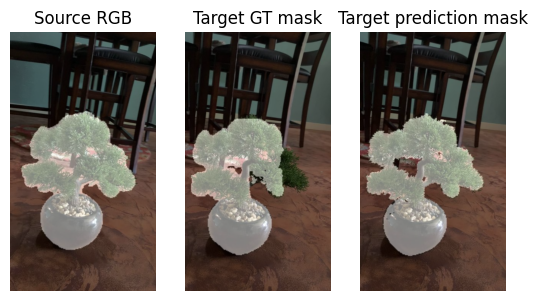

In [104]:
def overlay(img_t: torch.Tensor, mask_t: torch.Tensor):
    img = img_t.cpu().numpy().transpose(1, 2, 0)
    mask = mask_t.cpu().numpy().squeeze().astype(np.float32)
    mask = np.stack([mask] * 3, axis=-1)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    ret = (img + mask) / 2.0
    return ret


fig, ax = plt.subplots(1, 3)
ax[0].imshow(overlay(img_src, mask_src))
ax[0].set_title("Source RGB")
ax[1].imshow(overlay(img_tgt, mask_tgt))
ax[1].set_title("Target GT mask")
ax[2].imshow(overlay(img_tgt, seg_area_tgt))
ax[2].set_title("Target prediction mask")

for a in ax: a.axis("off")